# Spam Email Classification

In this notebook, we will build an email spam classifier using the "Enron" datasets of the [Harvard email datasets for cross dataset experiments](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/V7IFSM). The Harvard datasets is an eclectic collection of email datasets, among them are 6 datasets of emails from employees of [Enron Corporation](https://en.wikipedia.org/wiki/Enron).

We will experiment with a couple of "conventional" ML models and finally conclude with a more sophisticated neural network -- and see which of these models can successfully classify spam/non-spam emails and discern which model performs the best for our given dataset.

In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import spacy
from xgboost import XGBClassifier

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score

from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
import tensorflow as tf

## Read files:

Each of the Enron datasets is composed of `spam/` and `ham/` folders, where `spam/` contains spam emails (.txt files) and `ham/` contains non-spam emails. We'll first consolidate all the spam and ham text files into a single `spam/` and `ham/` folder.

Upon examination, we also notice that some of the documents are encoded in ISO-8859, which will cause issues as we try to process the data. We'll need to convert these files to UTF-8 or ASCII. One way we can convert the encoding is using Linux's `inconv` package, which is pre-installed in most distros.

The Bash syntax for converting a textfile, `FILE_NAME.txt`, to UTF-8 is as follows:
```bash
iconv -f ISO-8859-1 -t UTF-8//TRANSLIT FILE_NAME.txt -o FILE_NAME.txt
```

We'll now read all the files and store the text as a Pandas DataFrame. Since our emails are already split into `spam/` and `ham/` folders, we can simultaneously (and easily) label our data based on which folder we're reading from. We'll use `1` to delineate spam and `0` as non-spam emails.

In this particular dataset, all the email headers (other than the _Subject_) have already been removed. We also want to keep the _Subject_ header because it often contains useful information. So there's no pre-processing to be done at this step.

##### Read and save spam documents into a DataFrame:

In [55]:
spam_file_paths = glob.iglob('../data/data/spam/**')
df_spam = pd.DataFrame(columns=['text', 'label'])

In [56]:
for file_path in spam_file_paths:
    text = ''
    with open(file_path, 'r') as file:
        for line in file:
            text += line
        df_spam = pd.concat([df_spam, pd.DataFrame({'text': text, 'label': [1]})], ignore_index=True)

In [57]:
df_spam.head()

,text,label
0,Subject: netgoodssale . com - electronic produ...,1
1,Subject: failure notice\nhi . this is the qmai...,1
2,Subject: popular mechanics : do you need a fri...,1
3,Subject: \nhtml\nbody\npfont face = arialbufon...,1
4,Subject: why pay more when you can pay less ! ...,1


##### Read and save ham documents into a DataFrame:


In [58]:
ham_file_paths = glob.iglob('../data/data/ham/**')
df_ham = pd.DataFrame(columns=['text', 'label'])

In [59]:
for file_path in ham_file_paths:
    text = ''
    with open(file_path, 'r') as file:
        for line in file:
            text += line

        df_ham = pd.concat([df_ham, pd.DataFrame({'text': text, 'label': [0]})], ignore_index=True)

In [60]:
df_ham.head()

,text,label
0,Subject: re : wolf - reply - reply - reply\nwr...,0
1,Subject: hilcorp old ocean\ni have continued t...,0
2,Subject: merchanting metals update\nseveral re...,0
3,"Subject: meter 6461 , concorde churchill\none ...",0
4,Subject: weekly deal report\nattached is the w...,0


We'll now combine the spam and ham examples and split the data into train and test sets.

Our dataset consists of 33,716 examples, and we'll set aside 10% of that for our test set. (We'll set aside a portion for our validation set later.)

In [63]:
combined_dataset = pd.concat([df_ham, df_spam])

# Shuffle data:
combined_dataset = combined_dataset.sample(frac=1)

In [64]:
train_test_split = int(len(combined_dataset) * 0.9)

train_set = combined_dataset[:train_test_split]
test_set = combined_dataset[train_test_split:]

In [65]:
# Save data as csv:
train_set.to_csv('../data/train_set.csv', index=False)
test_set.to_csv('../data/test_set.csv', index=False)

## Explore Data:

Let's get a better understanding of our data.

We'll notice that our dataset fairly balanced, and that we have a sufficient number of both spam and ham examples for our ML models.

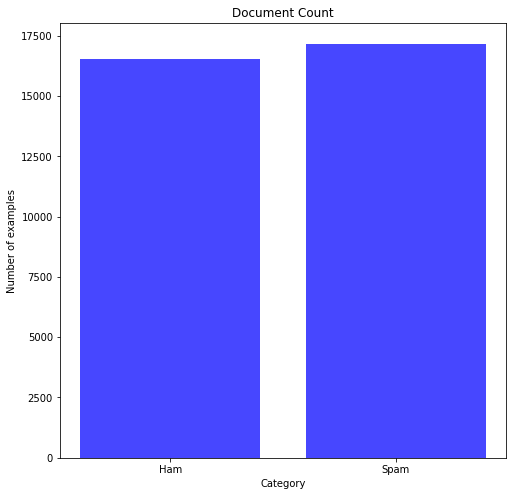

In [62]:
# Plot document count:

# Set size of plot:
plt.rcParams["figure.figsize"] = (8, 8)

fig, ax = plt.subplots()
ax.bar(
    ['Ham', 'Spam'],
    [len(df_ham), len(df_spam)],
    color='blue',
    alpha=0.72
)

plt.title('Document Count')
plt.xlabel('Category')
plt.ylabel('Number of examples')
plt.show()

In [66]:
len_ham = len(df_ham)
len_spam = len(df_spam)
print('Ham Count:', len_ham)
print('Spam Count:', len_spam)
print('Total:', len_spam + len_ham)

Ham Count: 16545
Spam Count: 17171
Total: 33716


We'll also take a look at the size (character length) of individual emails. Upon doing so, we'll notice that most of the emails are 720 characters or less. For comparison, a 500-word essay is approximately 3,000 - 3,500 characters. The largest document is an absurd 22,8377 characters in length. Since we will be creating a neural network (transformer), we will need our inputs to all be the same length (via truncating and padding). An input length of 22,000+ is far too large for such a model, so we will need to decide a max input length for truncation. Let's use 2,000 as the character limit -- only 19.25% of our data is larger than that size, and even if we lose information after truncation, we really should be able to discern whether the email is spam or not by the 2,000 character mark.

In [67]:
map_len = combined_dataset['text'].map(len)
max_length = map_len.max()
avg_length = map_len.sum() // len(combined_dataset)
median_length = int(map_len.median())
std_length = int(map_len.std())

print('Total number of examples:', len(combined_dataset))
print('Max length of document:', max_length)
print('Avg length of documents:', avg_length)
print('Median length of documents:', median_length)
print('Std of document length:', std_length)

Total number of examples: 33716
Max length of document: 228377
Avg length of documents: 1514
Median length of documents: 720
Std of document length: 4276


In [68]:
MAX_CHAR_LENGTH = 2000

percent_docs_over_2000 = combined_dataset['text'].map(lambda x: len(x) > MAX_CHAR_LENGTH).sum() / len(combined_dataset)
print(f'Percent of documents that have character length greater than 2,000: {percent_docs_over_2000 * 100:.2f}%')

Percent of documents that have character length greater than 2,000: 19.25%


## Process Data:

We will vectorize all the documents using TF-IDF (term frequency–inverse document frequency), which calculates the frequency of a word in a document (and reduces the weight of common words). Scikit-learn has the built-in [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) that does exactly this. But before we feed vectorized documents into our model pipeline, we should remove stop words from the documents -- we will use [spaCy](https://spacy.io/) for that.

In [3]:
# We only need lemmatizer from spaCy; see <https://spacy.io/usage/processing-pipelines#disabling>
nlp = spacy.load('en_core_web_trf',
                 disable=['tagger', 'parser', 'ner', 'entity_linker', 'entity_ruler', 'textcat', 'textcat_multilabel',
                          'attribute_ruler', 'senter', 'sentencizer', 'tok2vec', 'transformer']
                 )

In [4]:
# Remove stop words (parameter scaling):
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

Finally, we need to split train and test data into x and y (e.g. `x_train` and `y_train`):

In [8]:
x_train = train_set['text']
y_train = train_set['label']

x_test = test_set['text']
y_test = test_set['label']

In [20]:
print('Train size:', len(x_train))
print('Test size:', len(x_test))

Train size: 30344
Test size: 3372


## Support Vector Machine:
Since machine learning is an iterative process, we will try a couple of "conventional" machine learning models and see how well they perform in spam classification. We'll first try Linear Support Vector Classification, a standard text classification model. To measure the performance of the model, we'll use both accuracy and F1 score.

In [9]:
model_SVM = Pipeline(
    [
        ('vectorizer', TfidfVectorizer(stop_words=spacy_stopwords)),
        ('classifier', LinearSVC())
    ])

model_SVM.fit(x_train, y_train)

/home/deesus/.miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('classifier', LinearSVC())])

In [15]:
svm_train_predictions = model_SVM.predict(x_train)
svm_test_predictions = model_SVM.predict(x_test)

In [18]:
print('Train accuracy:', model_SVM.score(x_train, y_train))
print('Train F1 score:', f1_score(y_train, svm_train_predictions, average="macro"))
print(classification_report(y_train, svm_train_predictions))
print('\n')
print('Test accuracy:', model_SVM.score(x_test, y_test))
print('Test F1 score:', f1_score(y_test, svm_test_predictions, average="macro"))
print(classification_report(y_test, svm_test_predictions))

Train accuracy: 0.9998352227788031
Train F1 score: 0.9998351217843565
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14797
           1       1.00      1.00      1.00     15547

    accuracy                           1.00     30344
   macro avg       1.00      1.00      1.00     30344
weighted avg       1.00      1.00      1.00     30344



Test accuracy: 0.9896204033214709
Test F1 score: 0.9896118070852193
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1748
           1       0.98      1.00      0.99      1624

    accuracy                           0.99      3372
   macro avg       0.99      0.99      0.99      3372
weighted avg       0.99      0.99      0.99      3372



###### Analysis:
We were able to train our model quickly, and as you can see, has a 99.98% F1 score on the train set and 98.96% on the test set. So, it performed fairly well. The ~1% drop in performance between train and test sets probably indicates a small degree of over-fitting. SVMs tend to be resistant to over-fitting, but we likely can improve upon on this by fine-tuning the regularization parameter, `C`.

## XGBoost:
Gradient boosting, and specifically XGBoost, has become a popular choice for many ML tasks. Let's see how well the ensemble algorithm performs on our spam classification task. As a pre-processing step, we can use the same TF-IDF vectorizer and stop words that we used earlier.

In [21]:
model_xgb = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=spacy_stopwords)),
    ('classifier', XGBClassifier(objective='binary:logistic'))
])

model_xgb.fit(x_train, y_train)

/home/deesus/.miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtre...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [22]:
xgb_train_predictions = model_xgb.predict(x_train)
xgb_test_predictions = model_xgb.predict(x_test)

In [23]:
print('Train accuracy:', model_xgb.score(x_train, y_train))
print('Train F1 score:', f1_score(y_train, xgb_train_predictions, average="macro"))
print(classification_report(y_train, xgb_train_predictions))
print('\n')
print('Test accuracy:', model_xgb.score(x_test, y_test))
print('Test F1 score:', f1_score(y_test, xgb_test_predictions, average="macro"))
print(classification_report(y_test, xgb_test_predictions))

Train accuracy: 0.9902781439493804
Train F1 score: 0.990267552764396
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     14797
           1       0.98      1.00      0.99     15547

    accuracy                           0.99     30344
   macro avg       0.99      0.99      0.99     30344
weighted avg       0.99      0.99      0.99     30344



Test accuracy: 0.9798339264531435
Test F1 score: 0.9798266593280058
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1748
           1       0.96      1.00      0.98      1624

    accuracy                           0.98      3372
   macro avg       0.98      0.98      0.98      3372
weighted avg       0.98      0.98      0.98      3372



##### Analysis:
The XGBoost model did relatively well (97.98% F1 score), but didn't fit our dataset as well Linear SVM. It also took noticeably more time to train than the SVM model.

## Neural Network (Transformer):
Finally, we will build a more advanced model: a neural network. Unlike the previous models which used word frequencies, the neural network will "understand" the context of the words via [attention](https://arxiv.org/abs/1706.03762). As a result, we **don't** want to remove stop words in the documents; by stemming/lemmatizing we will be removing valuable information in the text.

We'll use a pretrained model from [Hugging Face](https://huggingface.co), rather than creating a new one from scratch, and then fine-tune it to our specific task. We'll use the [RoBERTa](https://arxiv.org/abs/1907.11692) architecture, which is an improved version of BERT; and more specifically, we'll use the ["distilled"](https://huggingface.co/distilroberta-base) version of RoBERTa, which performs slightly worse than regular RoBERTa, but has ~33% fewer parameters (and therefore is less resource intense and trains twice as fast).

In [69]:
dataset = Dataset.from_pandas(train_set)

In [70]:
MODEL_NAME = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [71]:
dataset = dataset.train_test_split(test_size=0.1)
dataset = dataset.shuffle(seed=2)

As mentioned before, we will truncate the document if it exceeds 2,000 characters. We also need to tokenize and pad our data.

In [72]:
def preprocess(examples):
    return tokenizer(examples['text'], truncation=True, max_length=MAX_CHAR_LENGTH)

tokenized_data = dataset.map(preprocess, batched=True, batch_size=8)
tokenized_data

  0%|          | 0/3414 [00:00<?, ?ba/s]

  0%|          | 0/380 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 27309
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 3035
    })
})

In [73]:
batch_size = 2
num_epochs = 15

In [74]:
batches_per_epoch = len(tokenized_data['train']) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

Although completely optional, we'll create a few additional callback functions:
1. A [learning rate scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules), which is a Keras/TensorFlow implementation of learning rate decay.
2. Saving checkpoints (model weights) after each epoch.
3. Early stoppage if the model's train accuracy achieves 99.7% accuracy.

In [75]:
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1e-5, end_learning_rate=5e-9, decay_steps=total_train_steps
)

In [76]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/checkpoints',
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True
)

In [77]:
class ThresholdStoppageCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdStoppageCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs["sparse_categorical_accuracy"]
        if train_acc >= self.threshold:
            self.model.stop_training = True

# If train accuracy reaches 99.7% accuracy, stop training:
threshold_stoppage_callback = ThresholdStoppageCallback(threshold=0.997)

In [78]:
tf_train_set = tokenized_data['train'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'label'],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')
)

tf_validation_set = tokenized_data['test'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'label'],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')
)

In [79]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
# Free up some memory:
del tokenized_data
del dataset
del combined_dataset

In [82]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [83]:
model_history = model.fit(
    tf_train_set,
    validation_data=tf_validation_set,
    epochs=num_epochs,
    callbacks=[model_checkpoint_callback, threshold_stoppage_callback]
)

Epoch 1/15
13654/13654 [==============================] - 1670s 122ms/step - loss: 0.0566 - sparse_categorical_accuracy: 0.9795 - val_loss: 0.0124 - val_sparse_categorical_accuracy: 0.9964
Epoch 2/15
13654/13654 [==============================] - 1661s 122ms/step - loss: 0.0162 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.0141 - val_sparse_categorical_accuracy: 0.9964
Epoch 3/15
13654/13654 [==============================] - 1663s 122ms/step - loss: 0.0078 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.0154 - val_sparse_categorical_accuracy: 0.9954


In [88]:
# Save weights:
model.save_weights('../models/saved_weights/distilroberta-base/weights_v1.h5')

#### Model Evaluation:

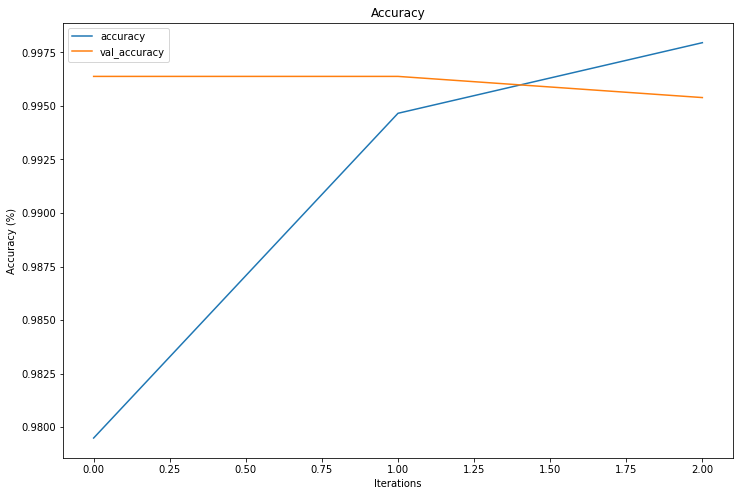

In [89]:
# Increase figure size:
plt.rcParams["figure.figsize"] = (12,8)

# Plot accuracy:
plt.plot(model_history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(model_history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.show()

In [90]:
def predict(text: str):
    encoded_input = tokenizer.encode(
        text,
        truncation=True,
        padding=True,
        max_length=MAX_CHAR_LENGTH,
        return_tensors="tf"
    )
    
    # Make prediction from logits:
    prediction = model.predict(encoded_input)['logits']
    prediction = tf.nn.softmax(prediction)
    prediction = np.argmax(prediction)
    
    return prediction

In [98]:
train_predictions = [predict(x) for x in train_set['text']]
train_set_y = train_set['label'].to_list()

In [101]:
print('Trainset F1 Score:', f1_score(train_set_y, train_predictions, average="macro"))
print('Trainset Accuracy:', accuracy_score(train_set_y, train_predictions))
print('\n')
print(classification_report(train_set_y, train_predictions))

Trainset F1 Score: 0.9986151088592974
Trainset Accuracy: 0.9986158713419457


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14797
           1       1.00      1.00      1.00     15547

    accuracy                           1.00     30344
   macro avg       1.00      1.00      1.00     30344
weighted avg       1.00      1.00      1.00     30344



In [91]:
test_predictions = [predict(x) for x in test_set['text']]
test_set_y = test_set['label'].to_list()

In [94]:
print('Testset F1 Score:', f1_score(test_set_y, test_predictions, average="macro"))
print('Testset Accuracy:', accuracy_score(test_set_y, test_predictions))
print('\n')
print(classification_report(test_set_y, test_predictions))

Testset F1 Score: 0.9940599731324763
Testset Accuracy: 0.9940688018979834


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1748
           1       1.00      0.99      0.99      1624

    accuracy                           0.99      3372
   macro avg       0.99      0.99      0.99      3372
weighted avg       0.99      0.99      0.99      3372



##### Analysis:
Our transformer network has a 99.86% F1 score on the train set and 99.40% on the test set, making it the best performing model of the three. Neural networks, especially attention-based networks, are intrinsically more sophisticated models that take into account word context, so it should be expected that it also performs the best. The model fit out dataset well, and importantly, didn't over-fit -- as evidenced by the fact that performance on the train set dropped by only 0.46%.

On the other hand, we spent more time setting up the model, creating various callbacks, etc. We trained the transformer model for 3 epochs (on GPU), but it still took ~83 minutes. This is expected though, as transformers are resource-intensive. It might be worth reconsidering our SVM model by fine-tuning its hyperparameters, because that model also performed well, but took a fraction of the time to train -- so we would be able to iterate faster on the SVM.

## Improvements:
Although our transformer model achieved an F1 score of 99.40%, this doesn't fully capture the problem task. In real life, a false positive (a normal email classified as "spam") is far worse than a false negative (spam that is not classified as "spam"). For example, consider an email service that marks an important message as "spam" -- the user may never see that message, which would be a serious problem. So, our spam classification problem is far from complete. We should analyze our false positives and understand to what extent are emails being incorrectly classified as "spam." Depending on the analysis, one possible way we could ameliorate false positives is by increasing the classification threshold (e.g. only classify an email as "spam" if the probability is greater than 0.8).